In [1]:
import torch
import torch.optim as optim
import numpy as np
import cvxpy as cp
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from datetime import datetime
from data_tools import PortfolioDataset, download_data
from models import PortfolioNet, create_cvxpy_layer, SensitivityAnalysisLayer
from utils import backtest

In [2]:
# Obtaining the dataset and dataloader
np.random.seed(42)
torch.manual_seed(42)

tickers = [
'AAPL', 'MSFT', 'GOOGL', 'META', 'NVDA',  # Technology
'PG', 'KO', 'PEP', 'WMT', 'COST',  # Consumer Goods
'JNJ', 'PFE', 'MRK', 'ABT', 'AMGN',  # Healthcare
'JPM', 'BAC', 'WFC', 'C', 'GS',  # Financials
'XOM', 'CVX', 'COP', 'SLB', 'OXY',  # Energy
'BA', 'CAT', 'UPS', 'DE', 'MMM',  # Industrials
'DIS', 'TGT', 'MCD', 'LVMUY', 'NFLX',  # Consumer Services
'LIN', 'NEM', 'CL', 'VMC', 'FCX',  # Materials
'AMT', 'PLD', 'SPG', 'O', 'EQIX',  # Real Estate
'NEE', 'DUK', 'XEL', 'SO', 'EXC'  # Utilities
]
returns = download_data(tickers, start_date='2015-01-01', end_date='2024-01-01')
returns = returns.values 

returns_tensor = torch.tensor(returns, dtype=torch.float32)

subseries_len = 28

dataset = PortfolioDataset(returns_tensor, subseries_len=subseries_len)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

n_assets = len(tickers)
input_dim = n_assets * subseries_len

rebalance_dates_backtest = [datetime(2024, month, 1) for month in range(1, 11)]

In [3]:
# Training step - Sensitivity Analysis Layer
np.random.seed(42)
torch.manual_seed(42)
model_sensitivity_analysis = PortfolioNet(input_dim=input_dim, n_assets=n_assets)

optimizer = optim.Adam(model_sensitivity_analysis.parameters(), lr=0.001)

lambda_, alpha, beta, gamma = 0.5, 1, 1, 0.1  # Weights mu loss, Sigma loss, portfolio loss 

z = cp.Variable(n_assets)
L = cp.Parameter((n_assets, n_assets))
mu = cp.Parameter(n_assets)

def f_(z, L, mu):
    return 0.5 * cp.sum_squares(L @ z) - lambda_*mu.T @ z
def g_(z, L, mu):
    return -z
def h_(z, L, mu):
    return cp.sum(z) - 1

sensitivity_layer = SensitivityAnalysisLayer(variables=[z], parameters=[L, mu], 
         objective=f_, inequalities=[g_], equalities=[h_])

num_epochs = 5
memory_stored = 0
for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", position=0)
    for _, (features_batch, mu_tags_batch, sigma_tags_batch) in progress_bar:
        optimizer.zero_grad()
        init_memory = torch.cuda.memory_allocated()
        
        mu_hat, L_hat = model_sensitivity_analysis(features_batch)
        Sigma_hat = torch.matmul(L_hat, L_hat.transpose(1, 2))
        mu_loss = torch.mean((mu_hat - mu_tags_batch) ** 2)
        sigma_loss = torch.mean((Sigma_hat - sigma_tags_batch) ** 2)
        optimal_values = sensitivity_layer.forward(L_hat, mu_hat)
        after_forward_memory = torch.cuda.memory_allocated()
        
        
        portfolio_loss = torch.mean(optimal_values)
        memory_stored += after_forward_memory - init_memory
        total_loss =  alpha*mu_loss  + beta*sigma_loss + gamma*portfolio_loss
        total_loss.backward()
        
        optimizer.step()
        epoch_loss += total_loss.item() * features_batch.size(0)
    
    epoch_loss /= len(dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}')
# print(f"Average memory stored from forward pass: {(memory_stored/(len(dataloader) * num_epochs)) / 1e6:.2f} MB")  # Needs to run on CUDA, if not output is 0!

Epoch 1/5: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s]


Epoch 1/5, Loss: -0.008912


Epoch 2/5: 100%|██████████| 70/70 [00:10<00:00,  6.71it/s]


Epoch 2/5, Loss: -0.020439


Epoch 3/5: 100%|██████████| 70/70 [00:10<00:00,  6.69it/s]


Epoch 3/5, Loss: -0.029079


Epoch 4/5: 100%|██████████| 70/70 [00:10<00:00,  6.73it/s]


Epoch 4/5, Loss: -0.032434


Epoch 5/5: 100%|██████████| 70/70 [00:10<00:00,  6.43it/s]

Epoch 5/5, Loss: -0.041821


Sharpe Ratio (Predicted Portfolio): 0.1161
Sharpe Ratio (Sample Portfolio): 0.0158
Sharpe Ratio (Equally Weighted Portfolio): 0.1489


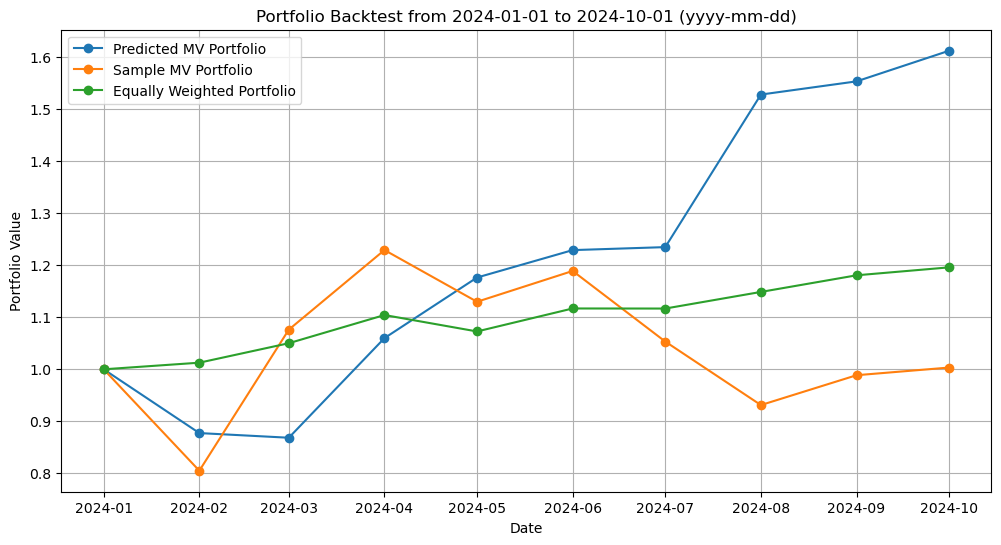

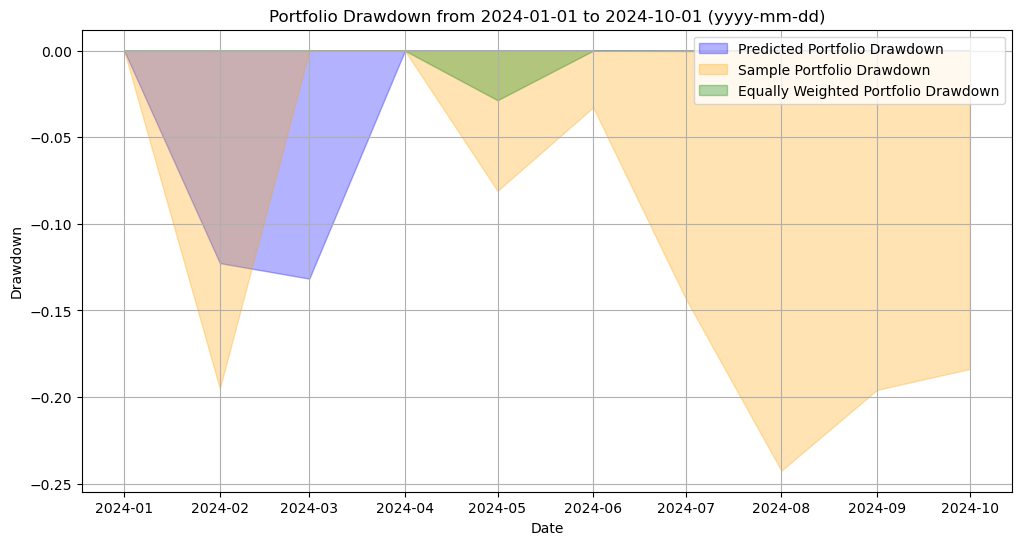

In [4]:
# Backtest - Sensitivity Analysis Layer
backtest(tickers, rebalance_dates_backtest, model_sensitivity_analysis)

In [6]:
# Training step - Differentiable Convex Optimization Layers
np.random.seed(42)
torch.manual_seed(42)
model_dcol = PortfolioNet(input_dim=input_dim, n_assets=n_assets)

optimizer = optim.Adam(model_dcol.parameters(), lr=0.001)

lambda_, alpha, beta, gamma = 0.5, 1, 1, 0.1  # Weights mu loss, Sigma loss, portfolio loss 
cvxpylayer = create_cvxpy_layer(n_assets, lambda_)

num_epochs = 5
memory_stored = 0
for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", position=0)
    for _, (features_batch, mu_tags_batch, sigma_tags_batch) in progress_bar:
        optimizer.zero_grad()
        init_memory = torch.cuda.memory_allocated()
        
        mu_hat, L_hat = model_dcol(features_batch)
        Sigma_hat = torch.matmul(L_hat, L_hat.transpose(1, 2))
        mu_loss = torch.mean((mu_hat - mu_tags_batch) ** 2)
        sigma_loss = torch.mean((Sigma_hat - sigma_tags_batch) ** 2)
        z_star, = cvxpylayer(mu_hat, L_hat)
        optimal_values = torch.bmm(z_star.unsqueeze(1), torch.bmm(Sigma_hat, z_star.unsqueeze(2))).squeeze() - torch.sum(mu_hat * z_star, dim=1)
        after_forward_memory = torch.cuda.memory_allocated()
        memory_stored += after_forward_memory - init_memory
        
        portfolio_loss = torch.mean(optimal_values)
        total_loss =  alpha*mu_loss + beta*sigma_loss + gamma*portfolio_loss
        total_loss.backward()
        
        optimizer.step()
        epoch_loss += total_loss.item() * features_batch.size(0)
    
    epoch_loss /= len(dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}')
# print(f"Average memory stored from forward pass: {(memory_stored/(len(dataloader) * num_epochs)) / 1e6:.2f} MB")  # Needs to run on CUDA, if not output is 0!

Epoch 1/5: 100%|██████████| 70/70 [00:11<00:00,  6.22it/s]


Epoch 1/5, Loss: -0.009012


Epoch 2/5: 100%|██████████| 70/70 [00:11<00:00,  6.29it/s]


Epoch 2/5, Loss: -0.020859


Epoch 3/5: 100%|██████████| 70/70 [00:11<00:00,  6.15it/s]


Epoch 3/5, Loss: -0.030398


Epoch 4/5: 100%|██████████| 70/70 [00:11<00:00,  6.25it/s]


Epoch 4/5, Loss: -0.038391


Epoch 5/5: 100%|██████████| 70/70 [00:11<00:00,  6.25it/s]

Epoch 5/5, Loss: -0.045633


Sharpe Ratio (Predicted Portfolio): 0.1600
Sharpe Ratio (Sample Portfolio): 0.0158
Sharpe Ratio (Equally Weighted Portfolio): 0.1489


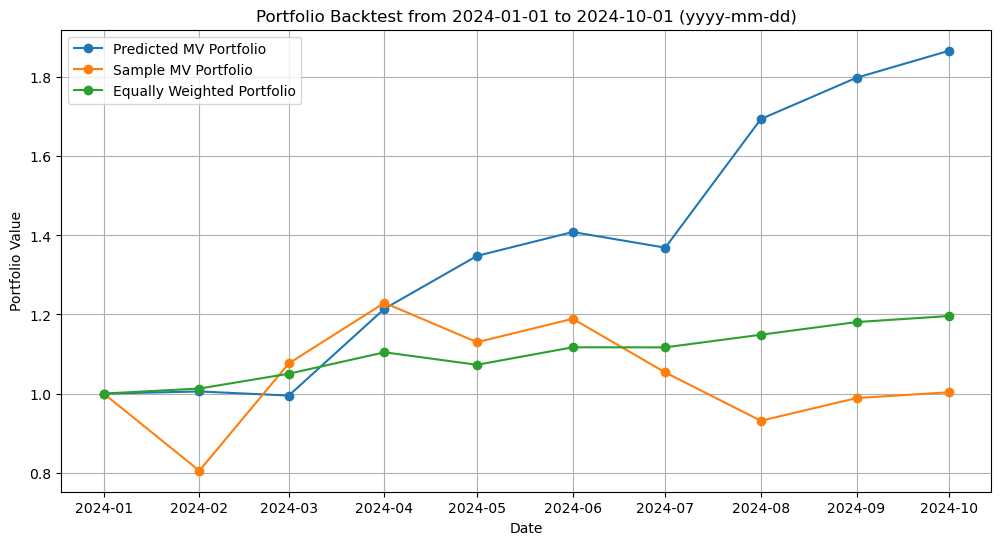

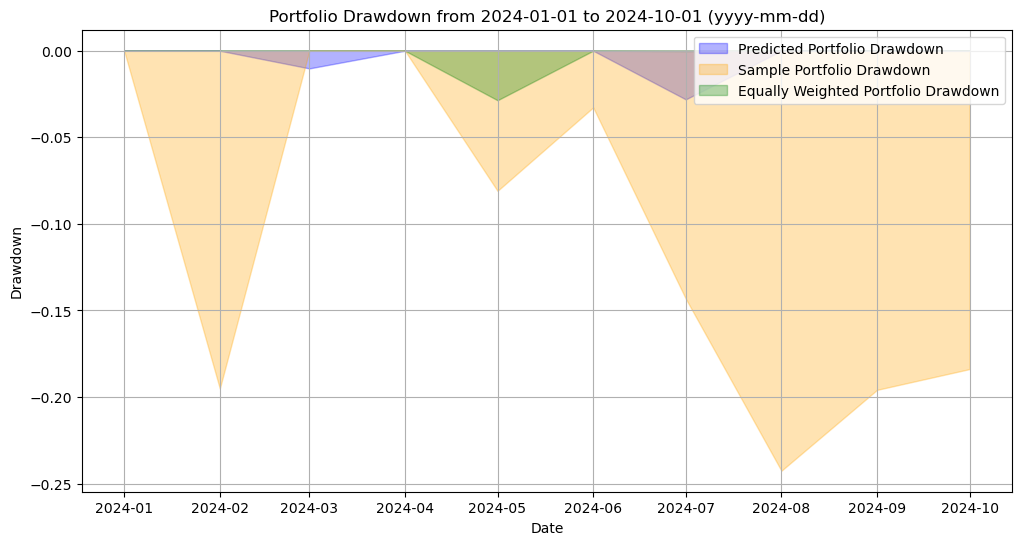

In [7]:
# Backtest - Differentiable Convex Optimization Layers
backtest(tickers, rebalance_dates_backtest, model_dcol)